In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.data import AUTOTUNE
import sentiment


DATASET_DIR = './goemotions/data-v2/'

In [2]:
classes = sentiment.load_classes(DATASET_DIR)
classes

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

Random seed: 1681944339


D:\sentiment-analysis\sentiment.py:286: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  class_mask = (train_df['labels'].str.contains(r'(^|,)' + label +
D:\sentiment-analysis\sentiment.py:613: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes, rotation=45, ha='right')


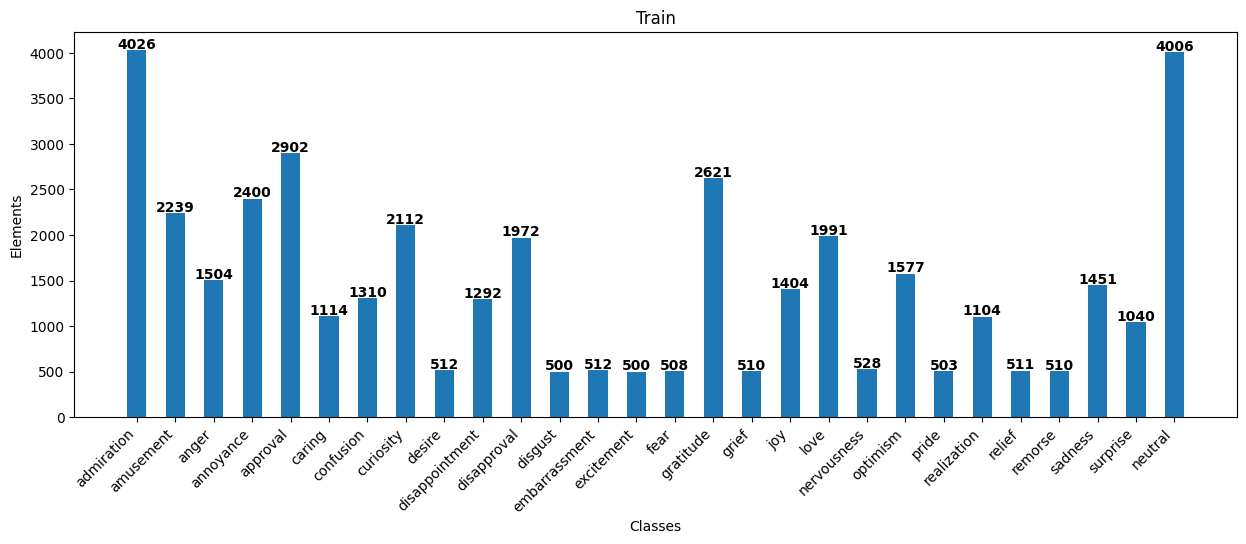

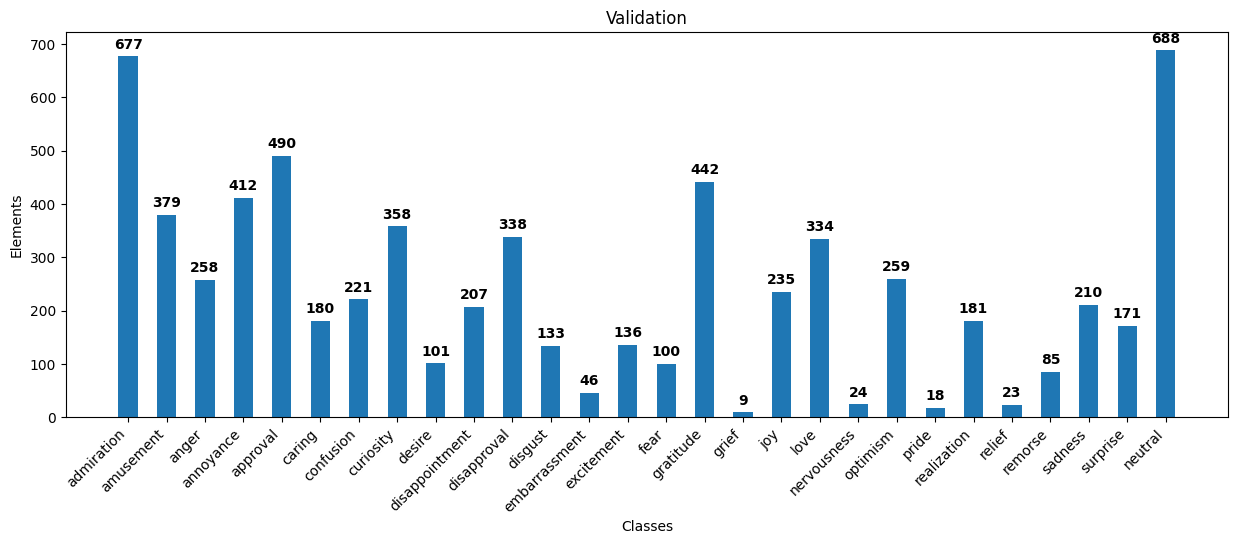

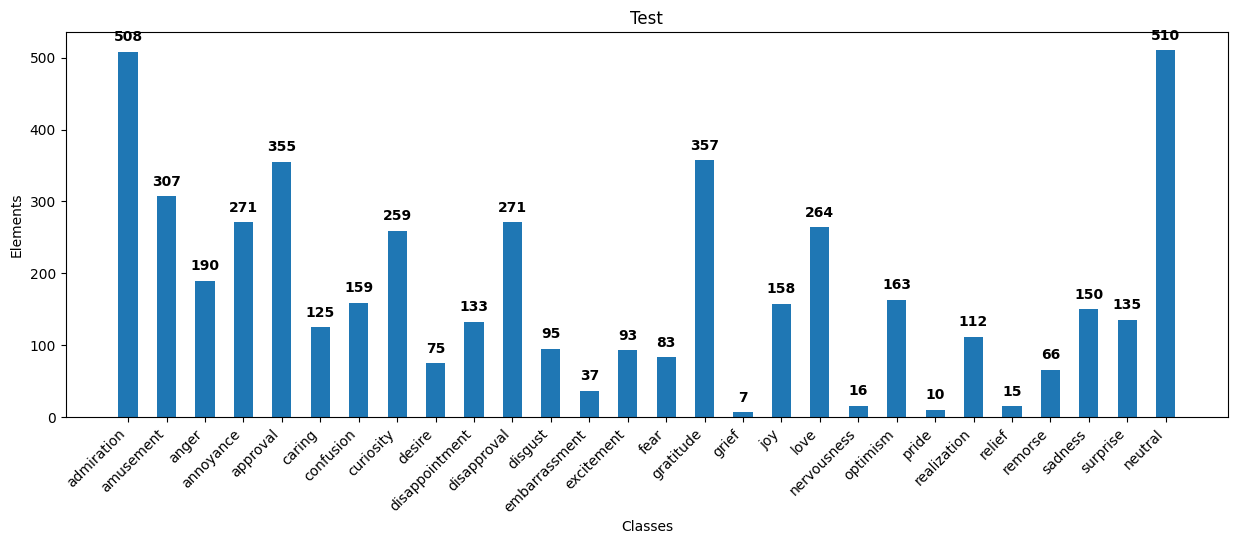

CPU times: total: 11.3 s
Wall time: 13.1 s


In [3]:
%%time
BATCH_SIZE = 64


train_df, val_df, test_df = sentiment.make_dataframes(DATASET_DIR,
                                                      fraction=0.85,
                                                      random=1681944339,
                                                      split_by_class=True,
                                                      clean=True,
                                                      cut_neutral=True,
                                                      test_only_singles=True,
                                                      oversample_low=True,
                                                      low_threshold=500)
dataframes = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
for title, df in dataframes.items():
    sentiment.plot_class_distr(df, classes, title)
train_ds = sentiment.make_ts_ds(train_df, classes, BATCH_SIZE, AUTOTUNE)
val_ds = sentiment.make_ts_ds(val_df, classes, BATCH_SIZE, AUTOTUNE)
test_ds = sentiment.make_ts_ds(test_df, classes, BATCH_SIZE, AUTOTUNE)

### Using tiny-BERT and its preprocess

In [4]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [5]:
text_test = ['I am feeling sad and lonely today']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1045 2572 3110 6517 1998 9479 2651  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [7]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.99999136  0.08191041 -0.9997363   0.9891061  -0.9994392   0.6426271
 -0.99642986 -0.04943833  0.08171504  0.04948686 -0.7958412  -0.04962895]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-1.1542702  -0.44949532 -3.3050992  ... -0.27842605 -0.4901824
   0.78527725]
 [-0.8928114  -0.68425363 -0.13896418 ... -1.6181747  -1.3698293
   0.50157887]
 [-0.9860739  -0.31338978 -1.2287494  ... -0.502259   -1.7966256
   0.5462902 ]
 ...
 [-1.6846545  -0.00387354 -0.12156503 ... -1.3318069  -0.74090356
   1.5787063 ]
 [-1.350074   -0.18482555 -0.18486801 ... -1.5990545  -0.8795686
   1.7834572 ]
 [-0.7529241  -0.72506434 -0.4427926  ... -1.5915537  -0.76583195
   1.740164  ]]


In [8]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dense(len(classes), activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [9]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.5861946  0.66545385 0.6163851  0.610716   0.63445836 0.5776838
  0.6499369  0.5877032  0.62449574 0.55992615 0.6108365  0.64425284
  0.63285846 0.5962066  0.67640936 0.63517886 0.55335885 0.67742074
  0.61785895 0.6324623  0.68666774 0.64168215 0.70504373 0.5576664
  0.5904582  0.66408503 0.57377785 0.6242828 ]], shape=(1, 28), dtype=float32)


In [10]:
classifier = build_classifier_model()

In [11]:
from tensorflow.keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

METRICS_THRESHOLD = 0.5

from official.nlp import optimization  # to create AdamW optimizer
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
metrics = sentiment.create_metrics(classes, METRICS_THRESHOLD)
loss = BinaryCrossentropy()
classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
hist = classifier.fit(x=train_ds, validation_data=val_ds, epochs=epochs,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
505/505 [==============================] - 613s 1s/step - loss: 0.2492 - precision@0.5/admiration: 0.2731 - recall@0.5/admiration: 0.0743 - precision@0.5/amusement: 0.0905 - recall@0.5/amusement: 0.1246 - precision@0.5/anger: 0.0000e+00 - recall@0.5/anger: 0.0000e+00 - precision@0.5/annoyance: 0.1183 - recall@0.5/annoyance: 0.0137 - precision@0.5/approval: 0.0923 - recall@0.5/approval: 0.0924 - precision@0.5/caring: 0.0209 - recall@0.5/caring: 0.0045 - precision@0.5/confusion: 0.0307 - recall@0.5/confusion: 0.0290 - precision@0.5/curiosity: 0.0612 - recall@0.5/curiosity: 0.0535 - precision@0.5/desire: 0.0169 - recall@0.5/desire: 0.1660 - precision@0.5/disappointment: 0.2000 - recall@0.5/disappointment: 7.7399e-04 - precision@0.5/disapproval: 0.0000e+00 - recall@0.5/disapproval: 0.0000e+00 - precision@0.5/disgust: 0.0149 - recall@0.5/disgust: 0.0060 - precision@0.5/embarrassment: 0.0000e+00 - recall@0.5/embarrassment: 0.0000e+00 - precision@0.5/excitement: 0.0000e+00 - recall

In [13]:
eval_metrics = classifier.evaluate(x=test_ds, return_dict=True)
sentiment.print_metrics(eval_metrics)

77/77 [==============================] - 22s 282ms/step - loss: 0.0927 - precision@0.5/admiration: 0.6680 - recall@0.5/admiration: 0.6693 - precision@0.5/amusement: 0.7672 - recall@0.5/amusement: 0.8371 - precision@0.5/anger: 0.6067 - recall@0.5/anger: 0.4789 - precision@0.5/annoyance: 0.2444 - recall@0.5/annoyance: 0.2841 - precision@0.5/approval: 0.3983 - recall@0.5/approval: 0.2704 - precision@0.5/caring: 0.4831 - recall@0.5/caring: 0.3440 - precision@0.5/confusion: 0.5254 - recall@0.5/confusion: 0.1950 - precision@0.5/curiosity: 0.5406 - recall@0.5/curiosity: 0.5907 - precision@0.5/desire: 0.5909 - recall@0.5/desire: 0.3467 - precision@0.5/disappointment: 0.2237 - recall@0.5/disappointment: 0.1278 - precision@0.5/disapproval: 0.4571 - recall@0.5/disapproval: 0.2952 - precision@0.5/disgust: 0.6444 - recall@0.5/disgust: 0.3053 - precision@0.5/embarrassment: 0.5769 - recall@0.5/embarrassment: 0.4054 - precision@0.5/excitement: 0.6842 - recall@0.5/excitement: 0.1398 - precision@0.5/fea

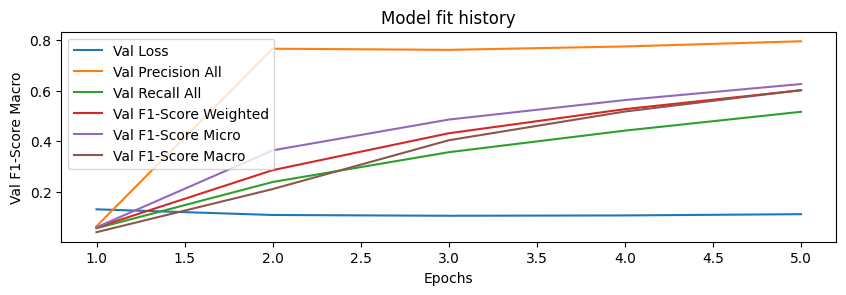

In [14]:
stats = hist.history
stats_graps = {
    'Val Loss': stats['val_loss'],
    'Val Precision All': stats['precision@0.5/all'],
    'Val Recall All': stats['recall@0.5/all'],
    'Val F1-Score Weighted': stats['f1_score@0.5/all'],
    'Val F1-Score Micro': stats['f1_score_micro@0.5/all'],
    'Val F1-Score Macro': stats['f1_score_macro@0.5/all'],
}
sentiment.plot_history(stats_graps)

In [15]:
sentiment.calc_TP_perc(test_ds, classifier)

0.4760357432981316

In [16]:
sentiments = sentiment.load_sentiments(DATASET_DIR)
sentiment_map = sentiment.map_sentiments(classes, sentiments)
sentiment.calc_TP_perc(test_ds, classifier, sentiment_map)

0.5936230706742486

In [17]:
sentiment.test_examples(classifier, classes)

I am feeling great today!: admiration 👏
The weather is so good: admiration 👏
I have performed well at the university: neutral ⚪
The war has started: neutral ⚪
He is desperate in this cruel world: annoyance 😒
I love the feeling when my girlfriend hugs me: love ❤️
WARNING! Model not sure (all predictions less than 0.5)
I hate monday mornings: anger 😡
Look forward to seeing you today: neutral ⚪
Merry Christmas! I told Santa you were good this year and asked him to bring you a year full of joy and pleasure : joy 😃
brilliant! Such a detailed review, it was a pleasure, thank you! Guys, make sure you find time to read :) Aaaaand you can actually choose sth new): admiration 👏 gratitude 🙏
WARNING! Model not sure (all predictions less than 0.5)
I have the new pan for pancakes.: admiration 👏
WARNING! Model not sure (all predictions less than 0.5)
I'm wearing a special red ribbon for luck.: approval 👍
OMG, yep!!! That is the final answer! Thank you so much!: gratitude 🙏
I am so glad this is over: 

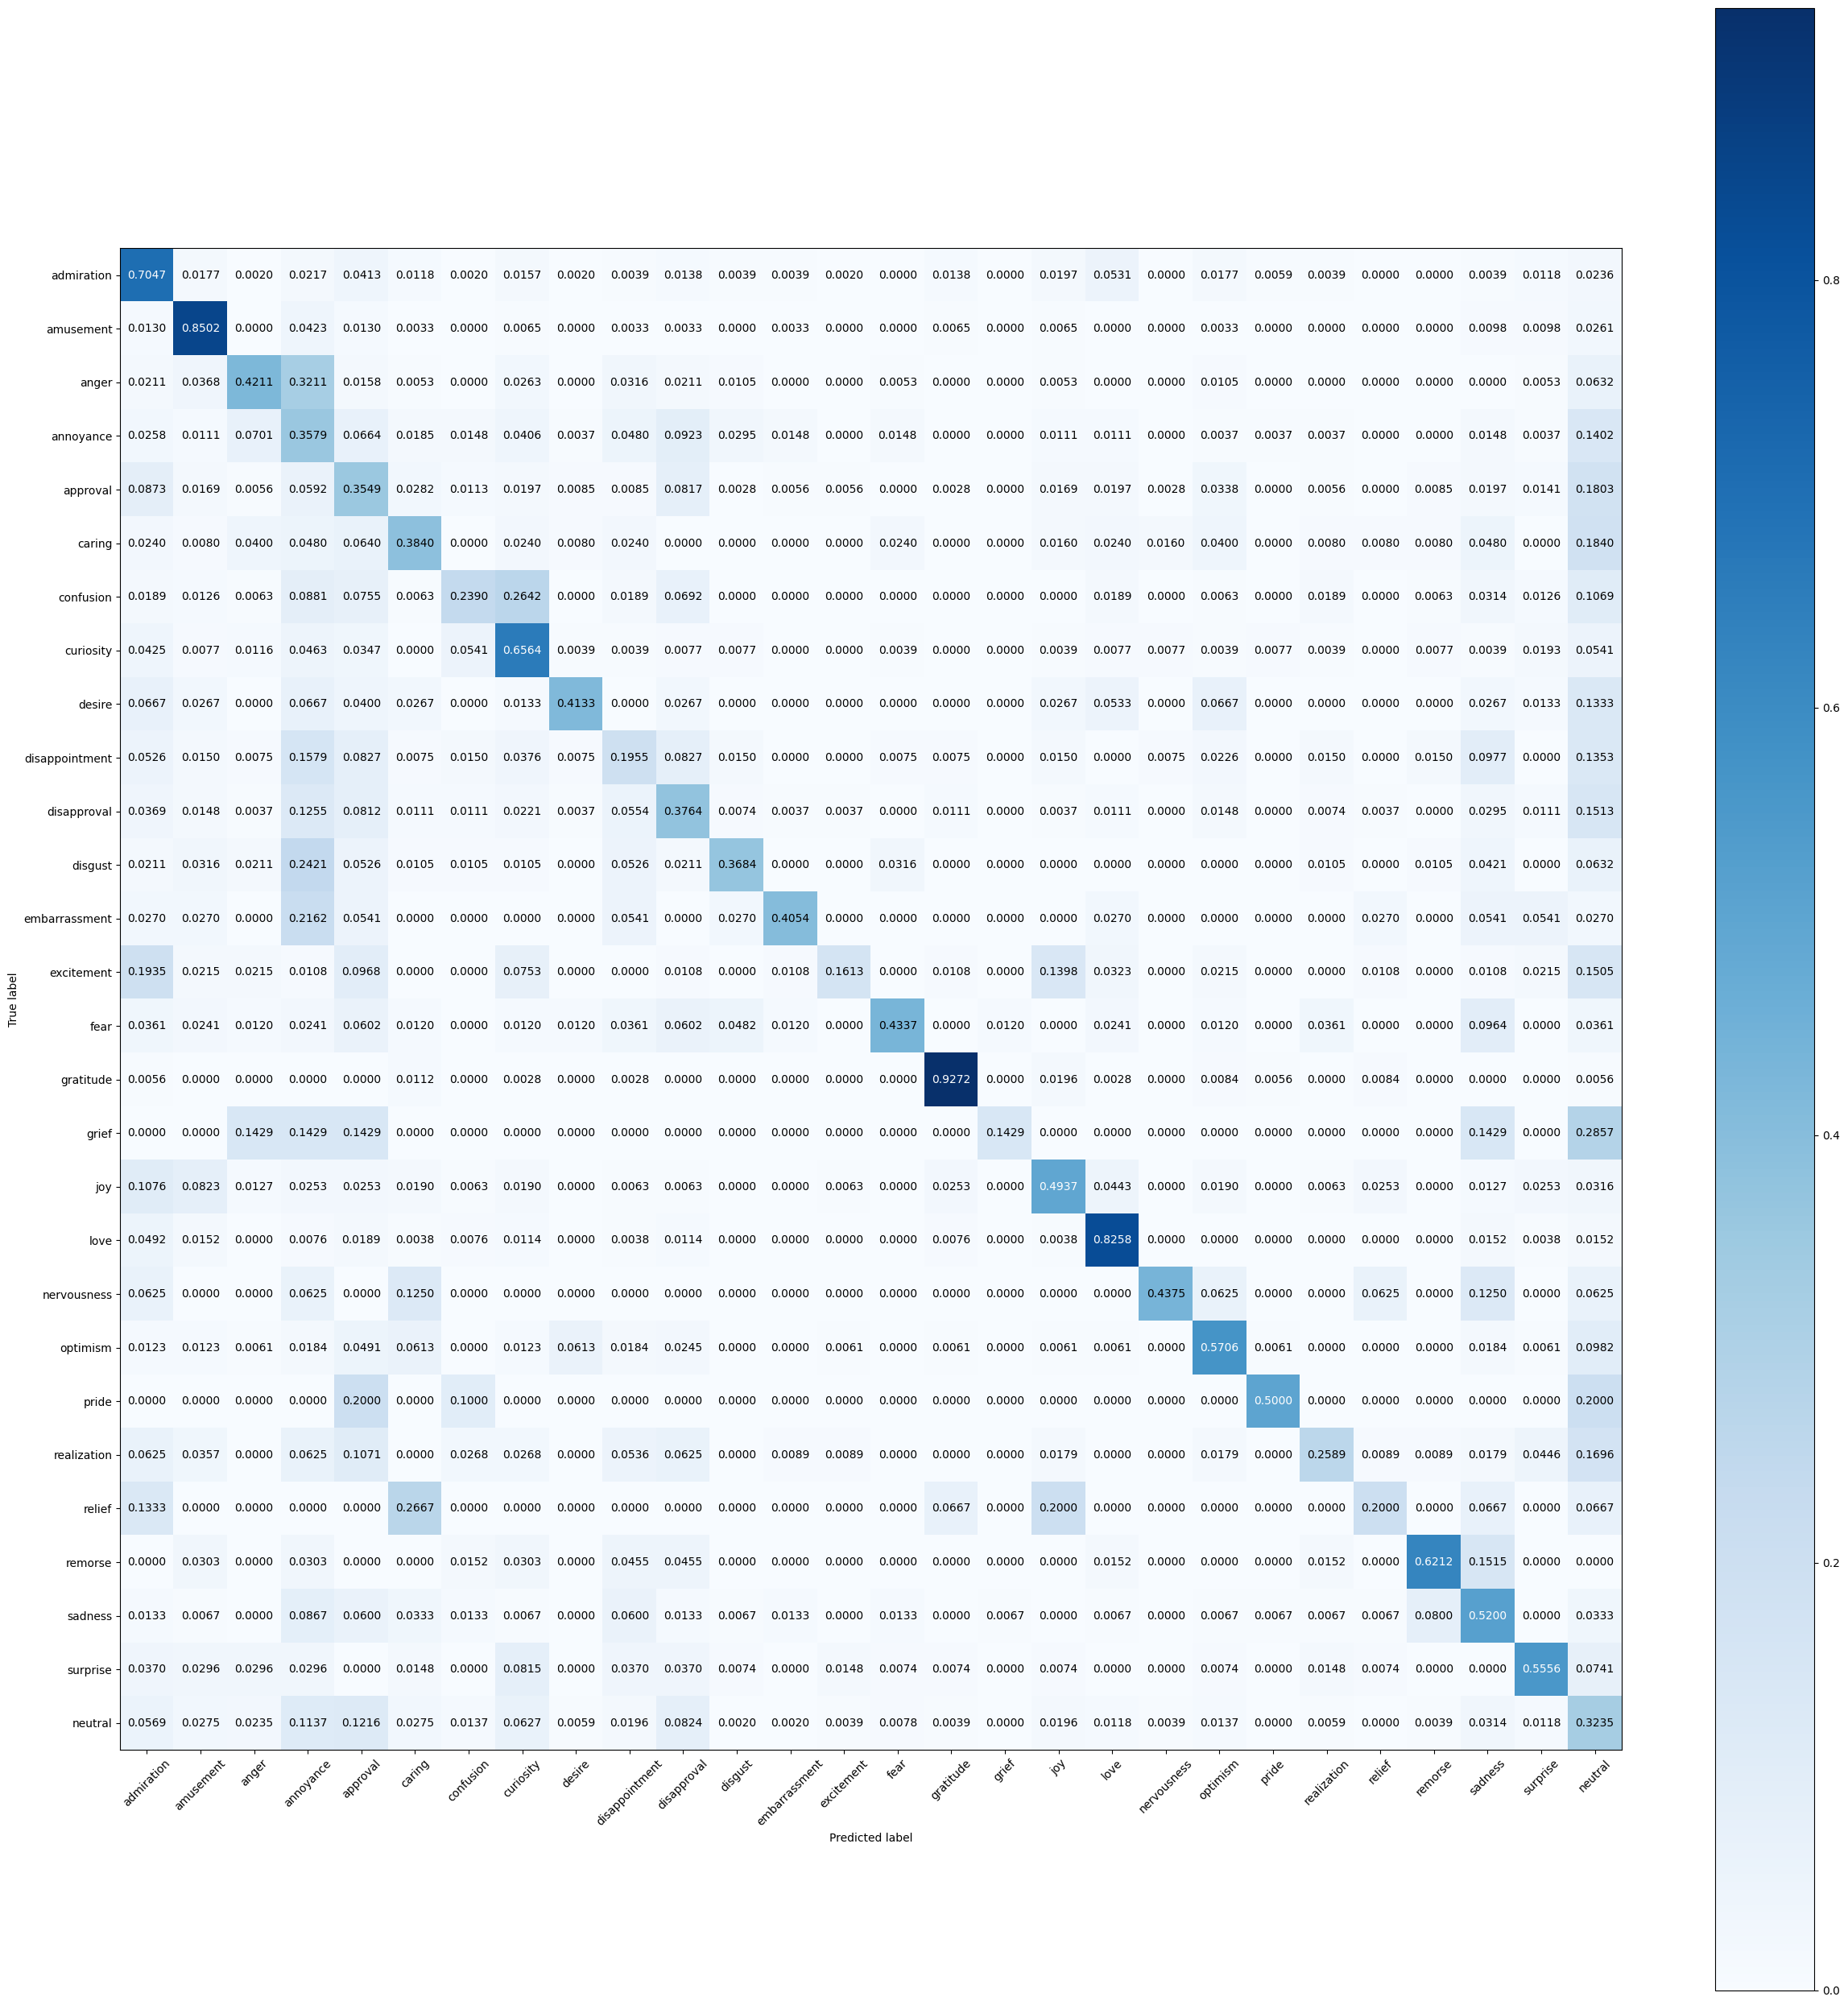

In [18]:
sentiment.plot_conf_mtrx_all(classifier, test_ds, classes)

2/2 [==============================] - 1s 140ms/step


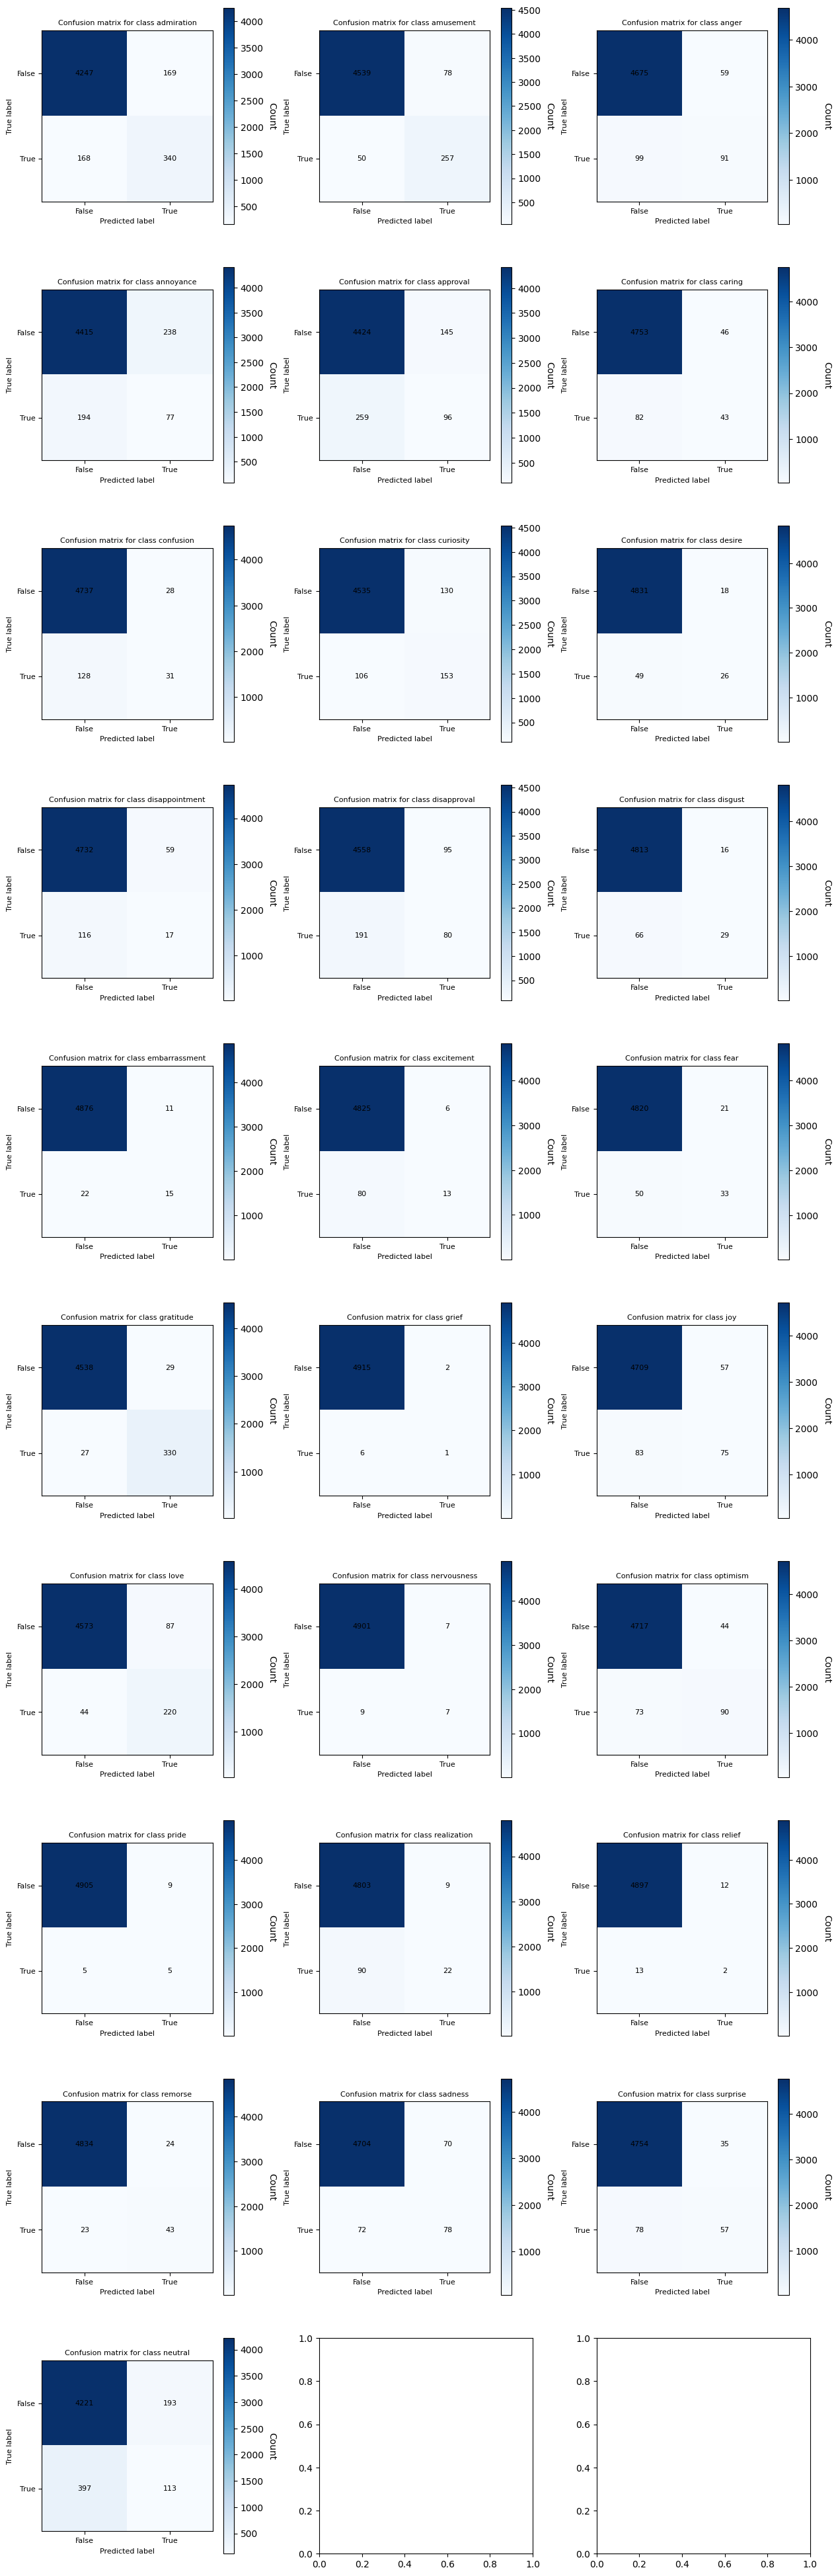

In [19]:
sentiment.plot_conf_mtrx_per_class(classifier, test_ds, classes)

In [20]:
classifier.save('./models/bert', include_optimizer=False)

INFO:tensorflow:Assets written to: ./models/bert\assets


INFO:tensorflow:Assets written to: ./models/bert\assets
